# 1-Import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD

# For normalization
import cv2
from skimage.exposure import match_histograms

os.environ["TF_KERAS"]='0'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# 2-Data Collection

In [2]:
df = pd.read_excel(r"C:\Users\John\Desktop\camcontrol\data\train.xlsx")
len(df)

762

In [3]:
df['Label'].fillna('other', inplace=True)
df.loc[df['Label']=='nc']

,Image_Path,Image_Size,Image_Width,Image_Height,Image_Mode,Image_Format,Date_Modified,Thumbnail,Label
61,C:\Users\John\Desktop\Camera_control\train\eur...,14195,960,1280,RGB,JPEG,1680517118,img,nc
62,C:\Users\John\Desktop\Camera_control\train\eur...,14308,960,1280,RGB,JPEG,1680517120,img,nc
78,C:\Users\John\Desktop\Camera_control\train\eur...,14221,960,1280,RGB,JPEG,1680517150,img,nc
95,C:\Users\John\Desktop\Camera_control\train\eur...,15434,960,1280,RGB,JPEG,1680517182,img,nc
96,C:\Users\John\Desktop\Camera_control\train\eur...,15539,960,1280,RGB,JPEG,1680517184,img,nc
238,C:\Users\John\Desktop\Camera_control\train\eur...,14502,960,1280,RGB,JPEG,1680517450,img,nc
239,C:\Users\John\Desktop\Camera_control\train\eur...,14476,960,1280,RGB,JPEG,1680517452,img,nc
319,C:\Users\John\Desktop\Camera_control\train\eur...,14125,960,1280,RGB,JPEG,1680517632,img,nc
320,C:\Users\John\Desktop\Camera_control\train\eur...,14241,960,1280,RGB,JPEG,1680517634,img,nc
341,C:\Users\John\Desktop\Camera_control\train\eur...,15917,960,1280,RGB,JPEG,1680517672,img,nc


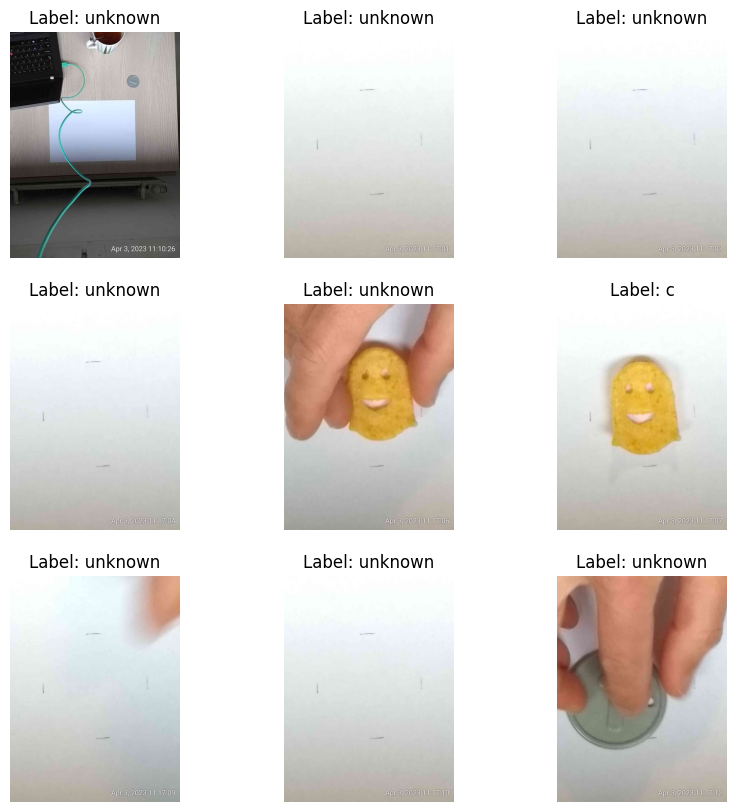

CPU times: total: 2.02 s
Wall time: 2.04 s


In [4]:
%%time
# Wall time 18s
# Visualisation de quelques images en vrac
plt.figure(figsize=(10, 10)) 

for i, row in df.head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(row['Image_Path']))
    plt.title(f"Label: {row['Label']}")
    plt.axis('off')

plt.show()

# 3-Model Preparation

In [5]:
# Parameter definition

# Number of classes
nb_lab = len(df['Label'].unique())

# Class list
le = LabelEncoder()
le.fit_transform(df['Label'])
list_lab = le.classes_

epochs_dic = {1:1, 2:15, 3:30}
batch_size_dic = {1:16, 2:32, 3:64}
optimizer_dic = {1:'Adam', 2:'rmsprop'}
normalization_dic = {1:None}
label_dic = {1:list_lab}
preprocessing_input_dic = {1:preprocess_input}

In [6]:
# Data augmentation function for train-val
def data_flow_fct(data, datagen, data_type=None, batch_size=None) :

    data_flow = datagen.flow_from_dataframe(data,
                                            #directory=dir_, # Pas besoin
                                            x_col='Image_Path',  # Utilisez 'image_path' comme colonne des chemins d'images
                                            y_col='Label',#_name',
                                            weight_col=None,
                                            target_size=(224, 224),
                                            classes=None,
                                            class_mode='categorical',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=42,
                                            subset=data_type)
    return data_flow

In [7]:
# Data augmentation function
def datagen_trainer(preprocessing_input):
    datagen_train = ImageDataGenerator(
    #    featurewise_center=True,
    #    featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25,# détermine le ration training/validation
        preprocessing_function=preprocessing_input)
    return datagen_train

def datagen_tester(preprocessing_input):
    datagen_test = ImageDataGenerator(
        validation_split=0,
        preprocessing_function=preprocess_input)
    return datagen_test

In [8]:
# Model creation function
def create_model_fct(nb_lab) :
    #weights_path = "/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5" # ATTENTION : activer hors connexion
    weights_path = 'imagenet'
    # Charger le modèle VGG16 pré-entraîné
    model0 = VGG16(include_top=False, weights=weights_path, input_shape=(224, 224, 3)) 
    
    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(224, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(nb_lab, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
       
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_dic[1], metrics=["accuracy"])

    print(model.summary())
    
    return model

In [9]:
# Step flow definition
def define_flow(preprocessing_flow, batch_size_flow):
    # Data augmentation for train-val
    train_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='training',batch_size=batch_size_flow)
    val_flow = data_flow_fct(data, datagen_trainer(preprocessing_flow), data_type='validation',batch_size=batch_size_flow)
    test_flow = data_flow_fct(data, datagen_tester(preprocessing_flow), data_type=None, batch_size=1)
    return train_flow, val_flow, test_flow

In [10]:
# Step model creation and training
def model_creation_training(train_flow, val_flow,epochs_entry):
    # 4min35 for epochs = 1 and batch_size = 32
    # Model creation and training
    with tf.device('/gpu:0'):

        # Model creation
        print('1/3-Model creation')
        model = create_model_fct(nb_lab)

        # Call back creation
        print('2/3-Callbacks')
        model_save_path = r"C:\Users\John\Desktop\camcontrol\models\model_best_weights.h5"
        checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
        callbacks_list = [checkpoint, es]

        # Training
        print('3/3-Training')
        history = model.fit(train_flow, epochs=epochs_entry, 
                            steps_per_epoch=len(train_flow),
                            callbacks=callbacks_list, 
                            validation_data=val_flow,
                            validation_steps=len(val_flow),
                            verbose=1)
    return model, history

In [11]:
# Step performance train_val
def performance_train_val(history, model, val_flow, batch_size_entry):
    # Performances
    print('1/6-val accuracy/epochs')
    show_history(history)
    plot_history(history, path=r"C:\Users\John\Desktop\camcontrol\reports\history_train_val.png")
    plt.close()

    print('2/6-predicting y_pred')
    #1min 28 for batch_size = 32
    y_pred = model.predict(val_flow, steps=len(val_flow), batch_size=batch_size_entry)

    print('3/6-getting y_val')
    nombre_total_val = len(val_flow) * batch_size_entry

    # Initialisation d'un tableau pour stocker les étiquettes réelles
    y_val = np.zeros((nombre_total_val, nb_lab))  

    # Itérer sur le générateur pour extraire les étiquettes réelles
    for i in range(len(val_flow)):
        _, batch_y_val = val_flow[i]  # Supposons que le générateur génère des paires (X_val, y_val)
        start_index = i * batch_size_dic[1]
        end_index = start_index + len(batch_y_val)
        y_val[start_index:end_index] = batch_y_val

    print('4/6-building the basic confusion matrix')
    # Obtenez les indices des classes prédites et réelles pour les échantillons disponibles
    y_val_indices = y_val.argmax(axis=1)[0:len(y_pred)]
    y_pred_indices = y_pred.argmax(axis=1)

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_indices, y_pred_indices)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val.argmax(axis=1)[0:len(y_pred)], y_pred.argmax(axis=1)))

    print('6/6-building the sns confusion matrix')
    # Finding the matching categorical labels for the numerical labels
    list_num_labels = sorted([x for x in set(y_val_indices)|set(y_pred_indices)])
    list_cat_labels = le.inverse_transform(list_num_labels)

    # Proceeding with sns
    df_cm = pd.DataFrame(cm, index=list_cat_labels, columns=list_cat_labels)

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_title("confusion matrix train_val")
    # Sauvegardez l'image dans un fichier
    plt.savefig(r'C:\Users\John\Desktop\camcontrol\reports\confusion_matrix_train_val.png')

    plt.show()

In [12]:
# Step performance test
# Performance
def performance_test(model, test_flow):
    print('getting y_pred')
    # Testing on whole dataset
    #y_pred = model.predict(images_np)
    y_pred = model.predict(test_flow, steps=len(test_flow), batch_size=1)

    print('4/6-building the basic confusion matrix')
    # get y_val and y_pred
    y_pred_indices = y_pred.argmax(axis=1)
    y_pred_cat = le.inverse_transform(y_pred_indices)

    y_val_cat = data['Label'][0:len(y_pred_cat)]

    # Générer la matrice de confusion
    cm = confusion_matrix(y_val_cat, y_pred_cat)

    # Afficher la matrice de confusion
    print(cm)

    # Afficher le rapport de classification
    print("\n5/6-building the classification report")
    print(classification_report(y_val_cat, y_pred_cat))

    print('6/6-building the sns confusion matrix')

    # Proceding with sns
    df_cm = pd.DataFrame(cm, index=label_dic[1], columns=label_dic[1])

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(df_cm, annot=True, cmap="Blues")

    # Ajouter des étiquettes aux axes
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    ax.set_title("confusion matrix test")    
    # Sauvegardez l'image dans un fichier
    plt.savefig(r'C:\Users\John\Desktop\camcontrol\reports\confusion_matrix_test.png')

    plt.show()
    return y_val_cat, y_pred_cat, y_pred

# 4-Training/Validation/Testing

Step 1 : data collection
Step 2 : flow definition
Found 572 validated image filenames belonging to 4 classes.
Found 190 validated image filenames belonging to 4 classes.
Found 762 validated image filenames belonging to 4 classes.
Step 3 : model creation and training
1/3-Model creation



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 

C:\Users\John\Desktop\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9755
Epoch 2: val_accuracy did not improve from 0.96842
36/36 [==============================] - 170s 5s/step - loss: 0.1018 - accuracy: 0.9755 - val_loss: 0.1695 - val_accuracy: 0.9579
Epoch 3/15
36/36 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9755
Epoch 3: val_accuracy improved from 0.96842 to 0.98947, saving model to C:\Users\John\Desktop\camcontrol\models\model_best_weights.h5
36/36 [==============================] - 172s 5s/step - loss: 0.0915 - accuracy: 0.9755 - val_loss: 0.0159 - val_accuracy: 0.9895
Epoch 4/15
36/36 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9843
Epoch 4: val_accuracy did not improve from 0.98947
36/36 [==============================] - 168s 5s/step - loss: 0.0639 - accuracy: 0.9843 - val_loss: 0.0386 - val_accuracy: 0.9895
Epoch 5/15
36/36 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9878
Epoch 5: 

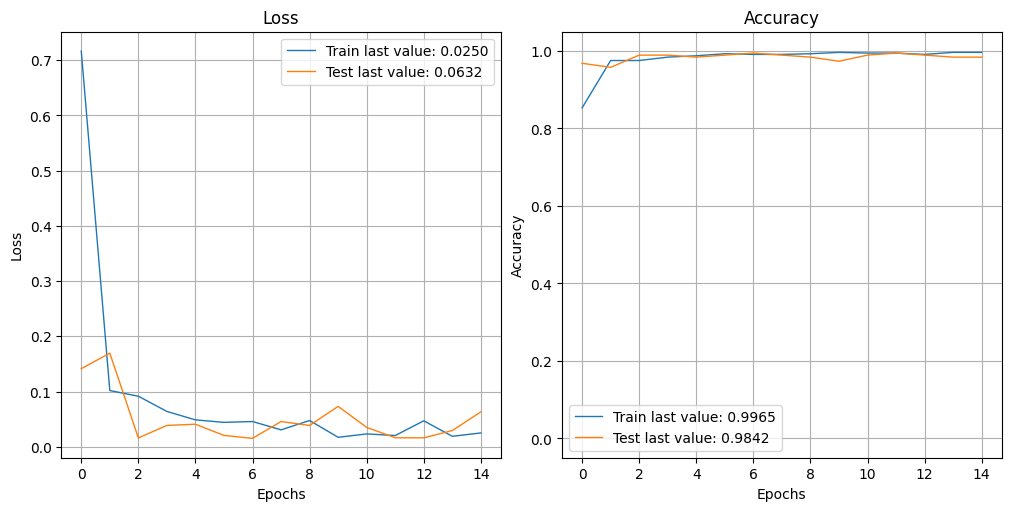

2/6-predicting y_pred
12/12 [==============================] - 44s 4s/step
3/6-getting y_val
4/6-building the basic confusion matrix
[[39  0  0  0]
 [ 1  4  0  0]
 [ 0  0 48  0]
 [ 1  0  0 97]]

5/6-building the classification report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        39
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00        48
           3       1.00      0.99      0.99        98

    accuracy                           0.99       190
   macro avg       0.99      0.95      0.96       190
weighted avg       0.99      0.99      0.99       190

6/6-building the sns confusion matrix


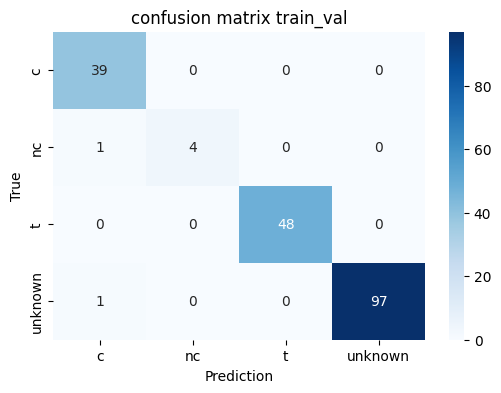

Step 5 : performance test
getting y_pred
762/762 [==============================] - 205s 269ms/step
4/6-building the basic confusion matrix
[[163   0   0   0]
 [  4  31   0   0]
 [  0   0 205   0]
 [  0   0   1 358]]

5/6-building the classification report
              precision    recall  f1-score   support

           c       0.98      1.00      0.99       163
          nc       1.00      0.89      0.94        35
           t       1.00      1.00      1.00       205
     unknown       1.00      1.00      1.00       359

    accuracy                           0.99       762
   macro avg       0.99      0.97      0.98       762
weighted avg       0.99      0.99      0.99       762

6/6-building the sns confusion matrix


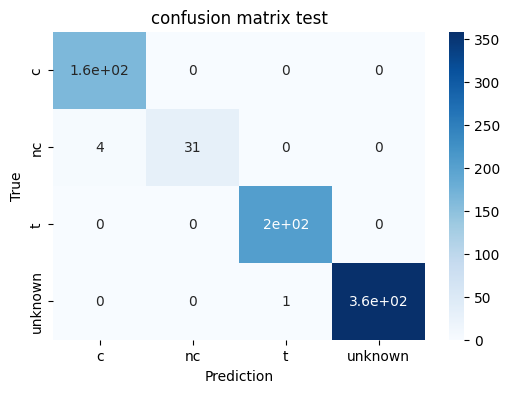

Step 6 : recording performance
CPU times: total: 2h 54min 49s
Wall time: 1h 1min 18s


,optimizer,method,test_accuracy,processing_time
0,rmsprop,preprocess_input,0.993438,3678.136125


In [13]:
%%time
# 2min 30s
print('Step 1 : data collection')
data = df

results = pd.DataFrame(columns=['optimizer','method','test_accuracy', 'processing_time'])
chrono = time()
for i in range(2,3):#rmsprop
    for j in range(1,2):#preprocess_input

        epochs_entry = epochs_dic[2]#15
        batch_size_entry = batch_size_dic[1]#16
        optimizer_entry = optimizer_dic[i]
        preprocessing_entry = preprocessing_input_dic[j]

        print('Step 2 : flow definition')
        train_flow, val_flow, test_flow = define_flow(preprocessing_entry, batch_size_entry)

        print('Step 3 : model creation and training')
        model_0, history_0 = model_creation_training(train_flow, val_flow, epochs_entry)

        print('Step 4 : performance train_val')
        # Step performance train_val
        performance_train_val(history_0, model_0, val_flow, batch_size_entry)

        #print('Step (en l'absence de flow) : préparation des images')
        # Step préparation des images (les images ne sont pas traitées !!)
        #images_np = image_prep_fct(data)
        #print(images_np.shape)

        print('Step 5 : performance test')
        y_val_cat, y_pred_cat, y_pred = performance_test(model_0, test_flow)

        print('Step 6 : recording performance')
        chrono = time() - chrono
        results.loc[len(results)] = [optimizer_entry, preprocessing_entry.__name__, accuracy_score(y_val_cat, y_pred_cat), chrono]
        chrono = time()
results

# 5-Visualisation

In [14]:
df['Pred'] = le.inverse_transform(np.argmax(y_pred, axis=1))

In [15]:
import pandas as pd
import os
import shutil
import openpyxl
from openpyxl.drawing.image import Image
import PIL
import cv2
from datetime import datetime, timedelta
from tqdm import tqdm

In [16]:
df.to_excel(r"C:\Users\John\Desktop\camcontrol\data\tested.xlsx", index=False)

In [17]:
# Définissons l'emplacement des différents dossiers et fichiers
# Le dossier où sont stockées les images d'entraînement
dir_train = r"C:\Users\John\Desktop\camcontrol\data\train"
# Le tableau des données inférées
dataset = r"C:\Users\John\Desktop\camcontrol\data\tested.xlsx"

In [18]:
# On va rajouter un thumbnail à chaque ligne
# 1-Instanciation un objet Openpyxl de tested.xlsx
try:
    # On essaie d'ouvrir le fichier Excel s'il existe déjà.
    file_path = dataset
    workbook = openpyxl.load_workbook(file_path)
    #print(f"Fichier Excel existant ouvert : {file_path}")
    
except FileNotFoundError:
    print("fichier non trouvé")

worksheet = workbook.active

In [19]:
# 2-On ajoute les thumbnails dans le document Openpyxl
for idc, image_path in tqdm(enumerate(df['Image_Path'])):
    # Resize cells ligne idx+2
    worksheet.row_dimensions[idc+2].height = 50

    # Collage du thumbnail sur la cellule colonne Hde la ligne idx+2
    # la première ligne qui contient les en-têtes des colonnes provoquent une exception
    try : 
        img = cv2.imread(df.iloc[idc,0])
    except :
        continue
    img = cv2.resize(img, (50, 50))
    
    # On sauvegarde l'image.son nom est img suivi de l'indice de la ligne où elle est collée
    img = cv2.imwrite(r'C:\Users\John\Desktop\camcontrol\data\interim\img{idc+2}.png', img)

    worksheet.add_image(Image(r'C:\Users\John\Desktop\camcontrol\data\interim\img{idc+2}.png'), anchor=f'H{idc+2}')#il faut que Image soit un objet Openpyxl et non pas PIL       

762it [00:17, 43.96it/s]


In [20]:
# 3-Sauvegarde du document data_set_train.xls avec ses thumbnails prêt à une labellisation manuelle
workbook.save(dataset)
workbook.close()